In [327]:
%pylab inline
import pyfits

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


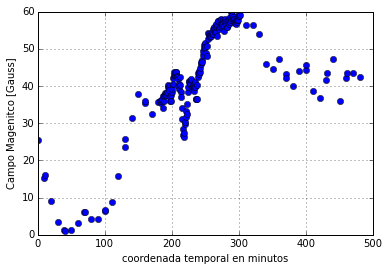

In [380]:
datos = pyfits.open('hmi.m_45s.magnetogram.subregion_x1y1.fits')
cols = datos[0].data
#x = linspace(0, 397, 398);y = linspace(0, 198, 199);z = linspace(0, 206, 207)
campo = cols[:,111,93] # Punto arbitrario de la imagen
tiempo=np.genfromtxt('times_delta.csv', delimiter=',')

plot(tiempo, campo, 'bo')
xlabel("coordenada temporal en minutos"); ylabel("Campo Magenitco [Gauss]"); grid()
datos.close()

###Modelo lineal
$$B(t)=a+Bt$$
$$a\sim[-200,200]$$
$$b\sim[-1,1]$$
Implemento correcciones para mejorar los ajustes:
$$a_0 =\bar{c}\pm \sigma/2$$
$$b_0 =\frac{c_n-c_0}{t_n-t_0}\pm \sigma/2$$

In [381]:
def modelo_lineal(t_obs,a,b):
    return a + b*t_obs

#funcion de likelihood lineal, sin exp
def likelihood(y_obs,y_m):
    chi_cuadrado= (1.0/2.0)*sum((y_obs-y_m)**2) # Se esta asumiendo que los sigmas = 1
    return -chi_cuadrado


In [382]:
a_walk = empty((0))
b_walk = empty((0))
like_walk = empty((0))

dd = std(campo)
mm = mean(campo)
nn = (campo[-1]-campo[0])/(tiempo[-1]-tiempo[0])

a_walk = append(a_walk,random.random()*2.0*dd +mm-1.0*dd)
b_walk = append(b_walk,random.random()*2.0*dd +nn-1.0*dd)

y_i = modelo_lineal(tiempo, a_walk[0],b_walk[0]) # y inicial
like_walk = append(like_walk,likelihood(campo,y_i)) # likelyhood
print(a_walk,b_walk,like_walk)
print(dd,mm,nn)

[ 48.8495656] [-9.98647725] [ -6.66211221e+08]
13.747 42.5996 0.0353104504684


In [383]:
iteraciones = 20000
for i in range(iteraciones):
    a_prime = random.normal(a_walk[i], 2.0*dd) # Desviacion estandar se asume que es 1 desde la definicion del likelyhood
    b_prime = random.normal(b_walk[i], 2.0*dd) # Entre mas desviacion estandar asigne a los parametros,
    # el metodo tiene en cuanta variaciones de mayor magnitud para los parametros.
    
    y_init = modelo_lineal(tiempo, a_walk[i], b_walk[i])
    y_prime = modelo_lineal(tiempo, a_prime, b_prime)
    
    like_prime = likelihood(campo, y_prime)
    like_init = likelihood(campo, y_init)
    
    
    alpha = like_prime-like_init 
    
    if(alpha>=0.0): # likelihood definido sin exp
            a_walk  = append(a_walk,a_prime)
            b_walk  = append(b_walk,b_prime)
            like_walk = append(like_walk, like_prime)
    else:
        beta = log(random.random())
        if(alpha>=beta):
            a_walk = append(a_walk,a_prime)
            b_walk = append(b_walk,b_prime)
            like_walk = append(like_walk, like_prime)
        else:
            a_walk = append(a_walk,a_walk[i])
            b_walk = append(b_walk,b_walk[i])
            like_walk = append(like_walk, like_init)            

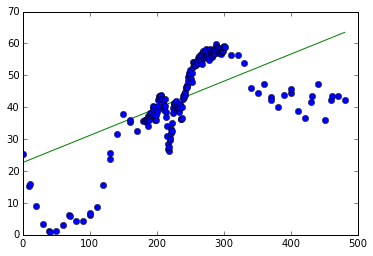

In [384]:
max_likelihood_id = argmax(like_walk)
best_a = a_walk[max_likelihood_id]
best_b = b_walk[max_likelihood_id]
best_campo = modelo_lineal(tiempo, best_a, best_b)
plot(tiempo,best_campo,'g-')
plot(tiempo,campo,'bo')

#####Ajuste curve_fit

In [385]:
from scipy.optimize import curve_fit

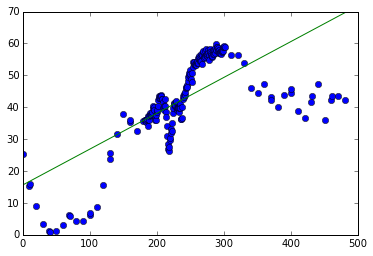

In [386]:
plot(tiempo,campo,'o')
args,info = curve_fit(modelo_lineal,tiempo,campo,p0=(0,0))
t = linspace(min(tiempo), max(tiempo), 500)
y = modelo_lineal(t,args[0],args[1])
plot(t,y,'g-')

###Lineal Gaussiano
$$B(t) = c + dt+\frac{1}{\sigma\sqrt{2\pi}}exp\left(-\frac{1}{2}\left(\frac{t-\mu}{\sigma}\right)^2\right)$$

In [387]:
def lineal_gauss(t_obs, c, d, sigma, mu):
    n1 = 1/(sigma*sqrt(2*pi))
    n2 = 0.5*((t_obs-mu)/sigma)**2
    return c +d*t_obs + n1*exp(-n2)

#funcion de likelihood, sin exp
def likelihood(y_obs,y_m):
    chi_cuadrado= (1.0/2.0)*sum((y_obs-y_m)**2) # Se esta asumiendo que los sigmas = 1
    return -chi_cuadrado

In [388]:
c_walk = empty((0))
d_walk = empty((0))
sigma_walk = empty((0))
mu_walk = empty((0))
like_walk = empty((0))

mm = mean(campo)
dd = std(campo)
nn = (campo[-1]-campo[0])/(tiempo[-1]-tiempo[0])
mm_t = mean(tiempo)

# Numeros iniciales
c_walk = append(c_walk,random.random()*2.0*dd +mm-1.0*dd)
d_walk = append(d_walk,random.random()*2.0*dd +nn-1.0*dd)
sigma_walk = append(sigma_walk, random.random()*10+35)#*2.0**dd - 1.0*dd)
mu_walk = append(mu_walk, random.random()*10.0 + 95.0)

y_i = lineal_gauss(tiempo, c_walk[0],d_walk[0],sigma_walk[0], mu_walk[0]) # y inicial
like_walk = append(like_walk,likelihood(campo,y_i)) # likelyhood
print(c_walk, d_walk, sigma_walk, mu_walk, like_walk)
print(mm,dd,nn,mm_t)

[ 30.96978938] [ 7.47205106] [ 40.62477554] [ 95.5731971] [ -3.68273734e+08]
42.5996 13.747 0.0353104504684 240.160708535


In [389]:
iteraciones = 20000
for i in range(iteraciones):
    c_prime = random.normal(c_walk[i], 2.0*dd) # Desviacion estandar se asume que es 1 desde la definicion del likelyhood
    d_prime = random.normal(d_walk[i], 2.0*dd)
    sigma_prime = random.normal(sigma_walk[i], 2.0*dd)
    mu_prime = random.normal(mu_walk[i], mm_t/5.0)
    
    y_init = lineal_gauss(tiempo, c_walk[i], d_walk[i], sigma_walk[i], mu_walk[i])
    y_prime = lineal_gauss(tiempo, c_prime, d_prime, sigma_prime, mu_prime)
    
    like_prime = likelihood(campo, y_prime)
    like_init = likelihood(campo, y_init)
    
    
    alpha = like_prime-like_init 
    
    if(alpha>=0.0): # likelihood definido sin exp
            c_walk = append(c_walk,c_prime)
            d_walk = append(d_walk,d_prime)
            sigma_walk = append(sigma_walk,sigma_prime)
            mu_walk = append(mu_walk,mu_prime)
            like_walk = append(like_walk, like_prime)
    else:
        beta = log(random.random())
        if(alpha>=beta):
            c_walk = append(c_walk,c_prime)
            d_walk = append(d_walk,d_prime)
            sigma_walk = append(sigma_walk,sigma_prime)
            mu_walk = append(mu_walk,mu_prime)
            like_walk = append(like_walk, like_prime)
        else:
            c_walk = append(c_walk, c_walk[i])
            d_walk = append(d_walk, d_walk[i])
            sigma_walk = append(sigma_walk,sigma_walk[i])
            mu_walk = append(mu_walk,mu_walk[i])
            like_walk = append(like_walk, like_walk[i])

c= 18.2422378655 
 d= 0.105234927417 
 sigma= 21.1572397571 
 mu= 29.2512510222


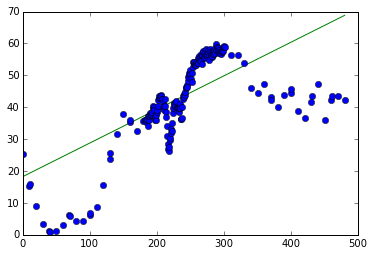

In [390]:
max_likelihood_id = argmax(like_walk)
best_c = c_walk[max_likelihood_id]
best_d = d_walk[max_likelihood_id]
best_sigma = sigma_walk[max_likelihood_id]
best_mu = mu_walk[max_likelihood_id]
best_campo = lineal_gauss(tiempo, best_c, best_d, best_sigma, best_mu)
plot(tiempo,best_campo,'g-')
plot(tiempo,campo,'bo')
print('c=',best_c,'\n','d=', best_d,'\n','sigma=', best_sigma,'\n','mu=',best_mu)

/home/j-camilo/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  from IPython.kernel.zmq import kernelapp as app
/home/j-camilo/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/j-camilo/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/j-camilo/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply
/home/j-camilo/anaconda3/lib/python3.4/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/j-camilo/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  app.l

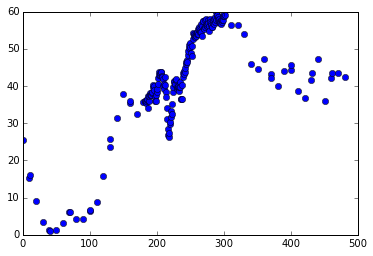

In [391]:
plot(tiempo,campo,'o')
args,info = curve_fit(lineal_gauss,tiempo,campo,p0=(0,0,0,0))
t = linspace(min(tiempo), max(tiempo), 500)
y = gauss(t,args[0],args[1],args[2],args[3])
plot(t,y,'g-')

###Lineal-paso
$$B(t)=f+gt+h\left(1+\frac{2}{\pi}tan^{-1}\left(n(t-t_0)\right)\right)$$

In [392]:
def paso(t,f,g,h,n,t0):
    return f + g*t + h*(1+2/pi*arctan(n*(t-t0)))

In [393]:
f_walk = empty((0))
g_walk = empty((0))
h_walk = empty((0))
n_walk = empty((0))
t0_walk = empty((0))
like_walk = empty((0))

mm = mean(campo)
dd = std(campo)
nn = (campo[-1]-campo[0])/(tiempo[-1]-tiempo[0])
mm_t = mean(tiempo)

# Numeros iniciales
f_walk = append(f_walk,random.random()*2.0*dd +mm-1.0*dd)
g_walk = append(g_walk,random.random()*2.0*dd +nn-1.0*dd)
h_walk = append(h_walk,random.random()*200.0 - 100.0)
n_walk = append(n_walk,random.random()*100)
t0_walk = append(t0_walk,random.random()*270+80) # t0 entre 80 y 350

y_i = paso(tiempo, f_walk[0], g_walk[0], h_walk[0], n_walk[0], t0_walk[0]) # y inicial
like_walk = append(like_walk,likelihood(campo,y_i)) # likelyhood
print(f_walk, g_walk, h_walk, n_walk, t0_walk, like_walk)
print(mm,dd,nn,mm_t)

[ 50.6720185] [ 10.01467285] [-79.49880672] [ 47.41913079] [ 317.82952449] [ -6.60588620e+08]
42.5996 13.747 0.0353104504684 240.160708535


In [394]:
iteraciones = 20000
for i in range(iteraciones):
    f_prime = random.normal(f_walk[i], 2.0*dd) 
    g_prime = random.normal(g_walk[i], 2.0*dd)
    h_prime = random.normal(h_walk[i], 50)
    n_prime = random.normal(n_walk[i], 50)
    t0_prime = random.normal(t0_walk[i], 270.0/2.0)
    
    y_init = paso(tiempo, f_walk[i], g_walk[i], h_walk[i], n_walk[i], t0_walk[i])
    y_prime = paso(tiempo, f_prime, g_prime, h_prime, n_prime, t0_prime)
    
    like_prime = likelihood(campo, y_prime)
    like_init = likelihood(campo, y_init)
    
    
    alpha = like_prime-like_init 
    
    if(alpha>=0.0): # likelihood definido sin exp
            f_walk = append(f_walk, f_prime)
            g_walk = append(g_walk, g_prime)
            h_walk = append(h_walk, h_prime)
            n_walk = append(n_walk, n_prime)
            t0_walk = append(t0_walk, t0_prime)
            like_walk = append(like_walk, like_prime)
    else:
        beta = log(random.random())
        if(alpha>=beta):
            f_walk = append(f_walk, f_prime)
            g_walk = append(g_walk, g_prime)
            h_walk = append(h_walk, h_prime)
            n_walk = append(n_walk, n_prime)
            t0_walk = append(t0_walk, t0_prime)
            like_walk = append(like_walk, like_prime)
        else:
            f_walk = append(f_walk, f_walk[i])
            g_walk = append(g_walk, g_walk[i])
            h_walk = append(h_walk, h_walk[i])
            n_walk = append(n_walk, n_walk[i])
            t0_walk = append(t0_walk, t0_walk[i])
            like_walk = append(like_walk, like_walk[i])

c= 18.2422378655 
 d= 0.105234927417 
 sigma= 21.1572397571 
 mu= 29.2512510222


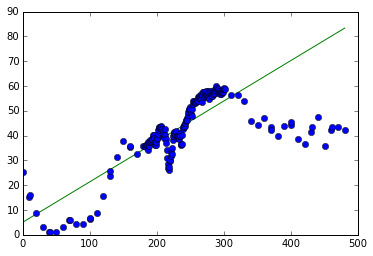

In [395]:
max_likelihood_id = argmax(like_walk)
best_f = f_walk[max_likelihood_id]
best_g = g_walk[max_likelihood_id]
best_h = h_walk[max_likelihood_id]
best_n = n_walk[max_likelihood_id]
best_t0 = t0_walk[max_likelihood_id]

best_campo = paso(tiempo, best_f, best_g, best_h, best_n, best_t0)
plot(tiempo,best_campo,'g-')
plot(tiempo,campo,'bo')
print('c=',best_c,'\n','d=', best_d,'\n','sigma=', best_sigma,'\n','mu=',best_mu)

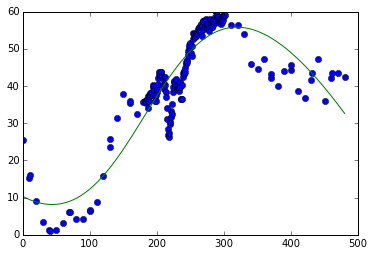

In [396]:
#curve_fit
plot(tiempo,campo,'o')
args,info = curve_fit(paso,tiempo,campo,p0=(0,0,0,0,0))
t = linspace(min(tiempo), max(tiempo), 500)
y = paso(t,args[0],args[1],args[2],args[3],args[4])
plot(t,y,'g-')

#Intentos Originales

In [115]:
for i in range(iteraciones):  
        a_prime = np.random.normal(a_walk[i], 0.1) 
        b_prime = np.random.normal(b_walk[i], 0.1)

        y_init = modelo_lineal(z, a_walk[i], b_walk[i])
        y_prime = modelo_lineal(z, a_prime, b_prime) #
    
        like_prime = likelihood(campo_m, y_prime)
        like_init = likelihood(campo_m, y_init)
    
        alpha = like_prime-like_init
        
        if(alpha>=1.0):
            a_walk  = np.append(a_walk,a_prime)
            b_walk  = np.append(b_walk,b_prime)
            like_walk = np.append(like_walk, like_prime)
        else:
            beta = log(np.random.random())
            if(beta<=alpha):
                a_walk = np.append(a_walk,a_prime)
                b_walk = np.append(b_walk,b_prime)
                like_walk = np.append(like_walk, like_prime)
            else:
                a_walk = np.append(a_walk,a_walk[i])
                b_walk = np.append(b_walk,b_walk[i])
                like_walk = np.append(like_walk, like_init)

NameError: name 'z' is not defined

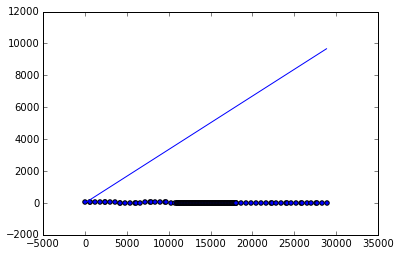

In [29]:
max_likelihood = np.argmax(likelihood)
best_a = a_walk[max_likelihood]
best_b = b_walk[max_likelihood]
best_campo = modelo_lineal(tiempo, best_a, best_b)
plot (tiempo,best_campo)
scatter(tiempo,campo_m)